OURunning Through EAZY Py and producing fitting templates to a given ZFOURGE catalogue

In [14]:

%matplotlib inline

import os
import glob
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from astropy.utils.exceptions import AstropyWarning
import eazy.hdf5
import time
import importlib
import sys
import eazy
from astropy.stats

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)
print('EAZYCODE = '+ str(os.getenv('EAZYCODE')) + '\n')

print(time.ctime() + '\n')

print(sys.version + '\n')

for module in ['numpy', 'scipy', 'matplotlib','astropy','eazy']:
    mod = importlib.import_module(module)
    print('{0:>20} : {1}'.format(module, mod.__version__))

ImportError: cannot import name 'nmad' from 'astropy.stats' (C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\astropy\stats\__init__.py)

Basic Settings Cell, can find more in depth changes further down

In [62]:
# Load ZFOURGE catalogue from local drive
test_title = 'test_2' # title of the test, eg. 1,2, A, B, Initial.
field = 'cdfs' #'cdfs', 'cosmos', or 'uds'

# Choose ID key for the catalogue
# A key designates what type of test you want to occur
id_key = 'low' # normal, high or low
id_range = {'normal': (0,30910),
           'high': (18000,20000),
           'low': (6000,10000)}

# AGN templates allocation
loop_number = 1 # what loop you are on, however in the test ipy this is not used
agn_sed = [0,1,2,3,4,5] # AGN templates to be added
use_galaxy_templates = True # set to True to use galaxy templates as well

In [52]:
# finding/creating the output directories

# Directories
if not os.path.isdir(f'outputs/{field}/{test_title}'):
    os.makedirs(f'outputs/{field}/{test_title}')

# Where to Save number data
output_directory = f'outputs/{field}/{test_title}/{field}_{test_title}_{id_key}_{agn_sed}_{use_galaxy_templates}' # output directory for images
key_data_file = f'outputs/{field}/{test_title}/key_data.csv'
headings = ['id_key', 'loop_number', 'agn_templates', 'galaxy templates', 'total_obj', 'total_agn', 'total_agn_percent', 'ir_count', 'ir_percent', 'radio_count', 'radio_percent', 'xray_count', 'xray_percent', 'mean_agn_frac', 'count', 'outlier_count', 'nmad_val', 'all_nmad_bin']

key_data = pd.DataFrame(columns=headings)
if not os.path.isfile(key_data_file):
    key_data.to_csv(key_data_file, index=False)


AGN Data Analysis

In [64]:
# making an agn catalogue with only selected range of objects

# Read the catalogue
os.getcwd()
object_range = id_range[id_key] # range of objects to be selected, determined by the key
agn_cat1 = sorted(glob.glob(f'zfourge/{field}/{field}.v?.?.??.cat')) # finds the catalogue
agn_cat2 = pd.read_csv(agn_cat1[0])
agn_cat_cut = agn_cat2[object_range[0]:object_range[1]] # select a range of objects with considerable content
agn_cat_cut.to_csv(f'inputs/cdfs_eazy_test.cat', index=False) # create a new catalogue with the selected objects

# Some analysis
agn_data1 = glob.glob(f'zfourge/{field}/{field}.v*.agn.*cat')
agn_data2 = pd.read_csv(agn_data1[0], sep="\s+", comment='#', header=None)[object_range[0]:object_range[1]]
total_count = object_range[1] - object_range[0] # all objects in the range

# total count
ids = []
for column in agn_data2.columns[1:]:  # Skip the first column (column of IDs)
    ids.extend(agn_data2.loc[agn_data2[column] == 1, 0].tolist())
ids = list(set(ids))
total_agn = len(ids) # all objects in the range that are AGN

ir_count = agn_data2[1].value_counts().get(1, 0)
ir_percent = ir_count/total_agn
radio_count = agn_data2[2].value_counts().get(1, 0)
radio_percent = radio_count/total_agn
xray_count = agn_data2[3].value_counts().get(1, 0)
xray_percent = xray_count/total_agn

# print the stats
print(f'Total number of objects: {total_count}')
print(f'Number of IR objects: {ir_count} ({ir_percent:.2%})')
print(f'Number of radio objects: {radio_count} ({radio_percent:.2%})')
print(f'Number of X-ray objects: {xray_count} ({xray_percent:.2%})')
print(f'Total number of AGN: {total_agn} ({total_agn/total_count:.2%})')

Total number of objects: 4000
Number of IR objects: 8 (26.67%)
Number of radio objects: 3 (10.00%)
Number of X-ray objects: 21 (70.00%)
Total number of AGN: 30 (0.75%)


In [ ]:
# Plot of % influence from AGN on each object

agn_per_dir = 'inputs/results.txt' # THIS IS JUST CDFS
all_bayes = pd.read_csv(agn_per_dir, sep="\s+", comment='#')

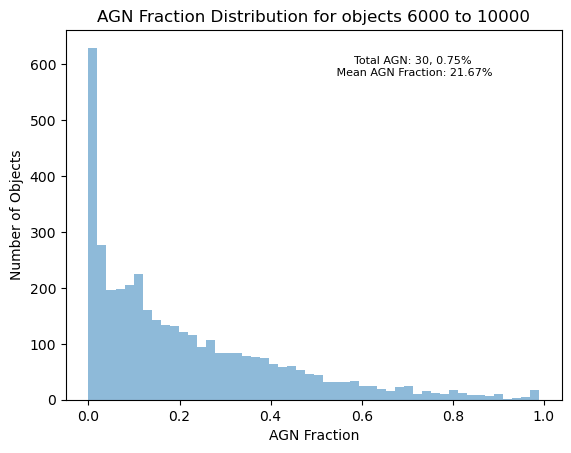

In [70]:
agn_frac = all_bayes['bayes.agn.fracAGN'][object_range[0]:object_range[1]] # AGN fraction for each object
mean_frac = np.mean(agn_frac)

plt.clf()
plt.hist(agn_frac, bins=50, alpha=0.5, label='AGN Fraction')

plt.xlabel('AGN Fraction')
plt.ylabel('Number of Objects')
plt.title(f'AGN Fraction Distribution for objects {object_range[0]} to {object_range[1]}')
plt.text(0.7,0.9, f'Total AGN: {total_agn}, {total_agn/total_count:.2%}\n '
                  f'Mean AGN Fraction: {mean_frac:.2%}', fontsize=8, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig(f'outputs/{field}/{test_title}/agn_frac_{field}_{id_key}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

In [5]:
# Load any templates from the AGN template library

temp_param = 'templates/eazy_v1.3.spectra.param' # basic parameter file, no agn templates
last_id = 9 # last id in the parameter file
empty_param = 'templates/eazy_v1.3_empty.param' # empty parameter file

agn_param = 'templates/eazy_v1.3_AGN.param' # parameter file with agn templates

# opening the parameter files, and reading the contents
with open(temp_param) as f:
    original_galaxy = f.read()

with open(empty_param) as f:
    original_empty = f.read()

agn_dir = 'templates/hlsp_agnsedatlas_observed/' # dir with all agn templates
agn_temp_all = os.listdir(agn_dir)
def agn_template_loader(templates, use_galaxy_templates=False):
    if use_galaxy_templates:
      copy = original_galaxy
      no_of_templates = len(templates)
      if no_of_templates == 0:
        open(agn_param, 'w').write(copy)
        print('No AGN templates added, just using galaxy templates')
        return
      for i in range(no_of_templates):
        id = last_id + i
        copy = copy + f'\n{id}   {agn_dir}{agn_temp_all[templates[i]]}   1.0 0 1.0    '
      open(agn_param, 'w').write(copy)
      print(f'AGN templates added to the parameter file {agn_param}, {last_id} galaxy templates used')
      return
    else:
      copy = original_empty
      no_of_templates = len(templates)
      if no_of_templates == 0:
        open(agn_param, 'w').write(copy)
        print('No AGN templates added, no templates used')
        return
      for i in range(no_of_templates):
        id = 0 + i
        copy = copy + f'\n{id}   {agn_dir}{agn_temp_all[templates[i]]}   1.0 0 1.0    '
      open(agn_param, 'w').write(copy)
      print(f'AGN templates added to the parameter file {agn_param}, no galaxy templates used')
      return

In [6]:
# EAZY parameters

# following files should be in the same dir as the project
param_file = f'base.param' #base parameter file, does not include all information
translate_file = glob.glob(f'zfourge/{field}/eazy/{field}.*.translate')

agn_template_loader(agn_sed, use_galaxy_templates=use_galaxy_templates) # loads the chosen AGN templates to the parameter file

params = {} # setting field specific parameters
params['Z_STEP'] = 0.05 # redshift step, defines the precision of each fit

#inputs
params['TEMPLATES_FILE'] = 'templates/eazy_v1.3_AGN.param' # parameter file containing which templates will be used
params['CACHE_FILE'] = f'zfourge/{field}/{field}.tempfilt'
params['CATALOG_FILE'] = f'inputs/{field}_eazy_test.cat' # for cut catalogue created in the earlier cell

#outputs
params['MAIN_OUTPUT_FILE'] = output_directory # output directory set earlier


AGN templates added to the parameter file templates/eazy_v1.3_AGN.param, 9 galaxy templates used


In [7]:
# Run EAZY with parameters

self = eazy.photoz.PhotoZ(param_file=param_file, translate_file=translate_file[0], zeropoint_file=None,
                         params=params, load_prior=True, load_products=False)

Read default param file: base.param
Read CATALOG_FILE: inputs/cdfs_eazy_test.cat
   >>> NOBJ = 4000
f_IRAC_80 e_IRAC_80 ( 21): IRAC/irac_tr4_2004-08-09.dat
f_IRAC_58 e_IRAC_58 ( 20): IRAC/irac_tr3_2004-08-09.dat
f_IRAC_45 e_IRAC_45 ( 19): IRAC/irac_tr2_2004-08-09.dat
f_IRAC_36 e_IRAC_36 ( 18): IRAC/irac_tr1_2004-08-09.dat
f_Ks e_Ks (255): FOURSTAR/Ks_cam_optics_sky.txt
f_KsHI e_KsHI (269): VLT/hawki_k_ETC.dat
f_J1 e_J1 (249): FOURSTAR/J1_cam_optics_sky.txt
f_J2 e_J2 (250): FOURSTAR/J2_cam_optics_sky.txt
f_J3 e_J3 (251): FOURSTAR/J3_cam_optics_sky.txt
f_Hs e_Hs (254): FOURSTAR/Hshort_cam_optics_sky.txt
f_Hl e_Hl (253): FOURSTAR/Hlong_cam_optics_sky.txt
f_U e_U (103): ESO/vimos_u.res
f_B e_B (  1): hst/ACS_update_sep07/wfc_f435w_t77.dat
f_V e_V (  4): hst/ACS_update_sep07/wfc_f606w_t77.dat
f_R e_R (260): ESO/VIMOS/R.dat
f_I e_I (  5): hst/ACS_update_sep07/wfc_f775w_t77.dat
f_Z e_Z (  7): hst/ACS_update_sep07/wfc_f850lp_t77.dat
f_F125W e_F125W (203): hst/wfc3/IR/f125w.dat
f_F140W e_F140W 

100%|██████████| 15/15 [00:16<00:00,  1.11s/it]


Template   0: eazy_v1.1_sed1.dat (NZ=1).
Template   1: eazy_v1.1_sed2.dat (NZ=1).
Template   2: eazy_v1.1_sed3.dat (NZ=1).
Template   3: eazy_v1.1_sed4.dat (NZ=1).
Template   4: eazy_v1.1_sed5.dat (NZ=1).
Template   5: eazy_v1.1_sed6.dat (NZ=1).
Template   6: eazy_v1.1_sed7.dat (NZ=1).
Template   7: c09_del_8.6_z_0.019_chab_age09.40_av2.0.dat (NZ=1).
Template   8: erb2010_highEW.dat (NZ=1).
Template   9: hlsp_agnsedatlas_multi_multi_2masxj13000533+1632151_multi_v1_spec-obs.dat (NZ=1).
Template  10: hlsp_agnsedatlas_multi_multi_3c120_multi_v1_spec-obs.dat (NZ=1).
Template  11: hlsp_agnsedatlas_multi_multi_3c273_multi_v1_spec-obs.dat (NZ=1).
Template  12: hlsp_agnsedatlas_multi_multi_3c351_multi_v1_spec-obs.dat (NZ=1).
Template  13: hlsp_agnsedatlas_multi_multi_3c390-3_multi_v1_spec-obs.dat (NZ=1).
Template  14: hlsp_agnsedatlas_multi_multi_ark120_multi_v1_spec-obs.dat (NZ=1).
Process templates: 17.668 s


48it [00:00, 250.58it/s]


Iteration:  0


100%|██████████| 48/48 [00:05<00:00,  8.37it/s]


Compute best fits
fit_best: 0.8 s (n_proc=1,  NOBJ=3719)
Fit 6.6 s (n_proc=8, NOBJ=3811)
Iterative correction - zeropoint / template


C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Iteration:  1


100%|██████████| 48/48 [00:05<00:00,  8.65it/s]


Compute best fits
fit_best: 0.8 s (n_proc=1,  NOBJ=3723)
Fit 6.5 s (n_proc=8, NOBJ=3811)
Iterative correction - zeropoint / template


C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Iteration:  2


100%|██████████| 48/48 [00:05<00:00,  8.60it/s]


Compute best fits
fit_best: 0.8 s (n_proc=1,  NOBJ=3724)
Fit 6.5 s (n_proc=8, NOBJ=3811)
Iterative correction - zeropoint / template


C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


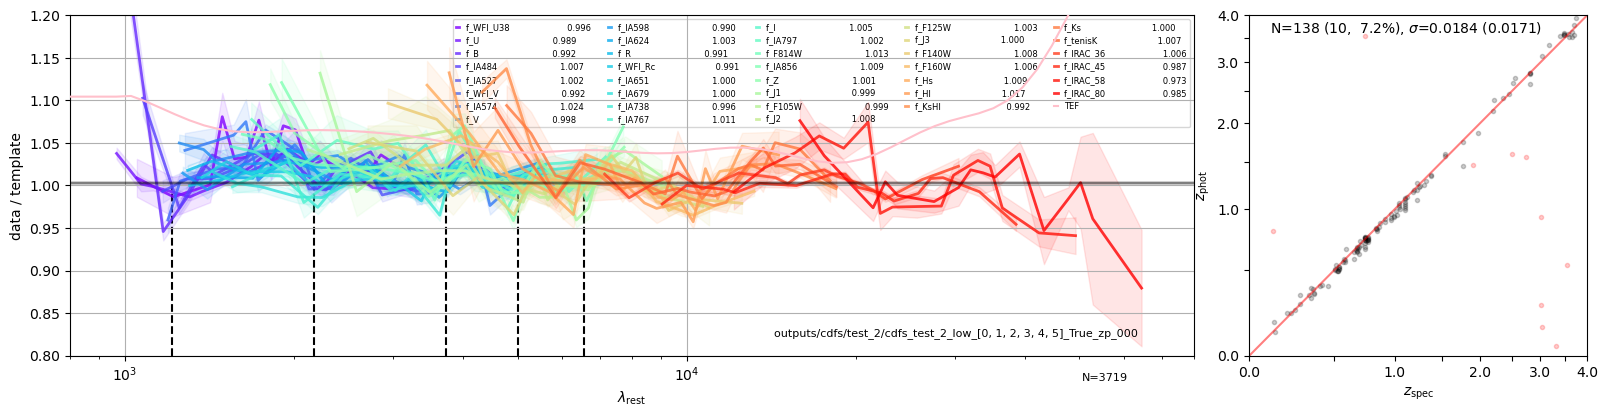

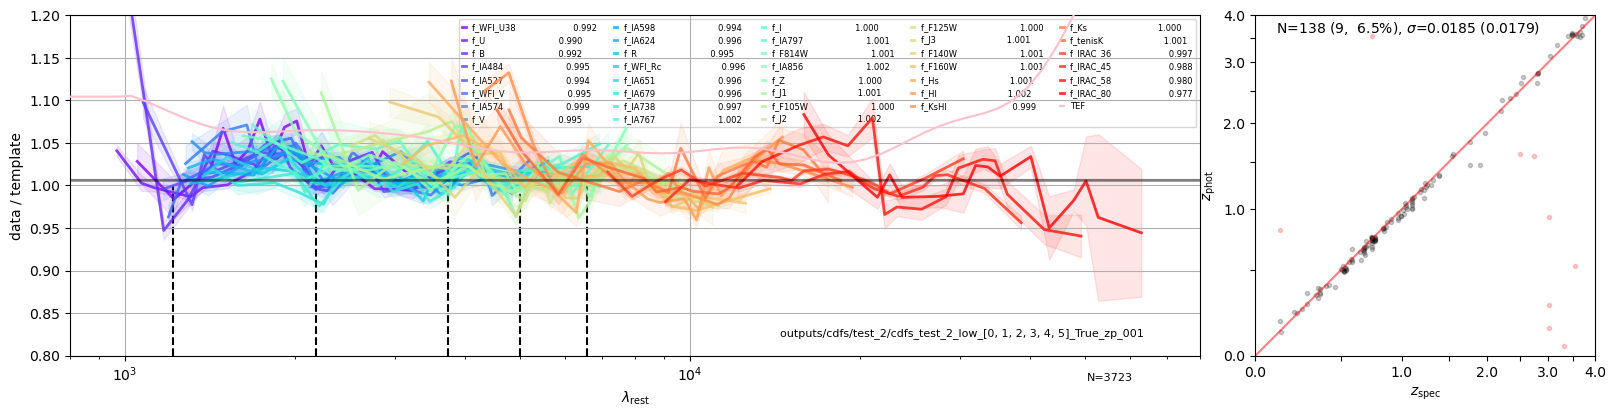

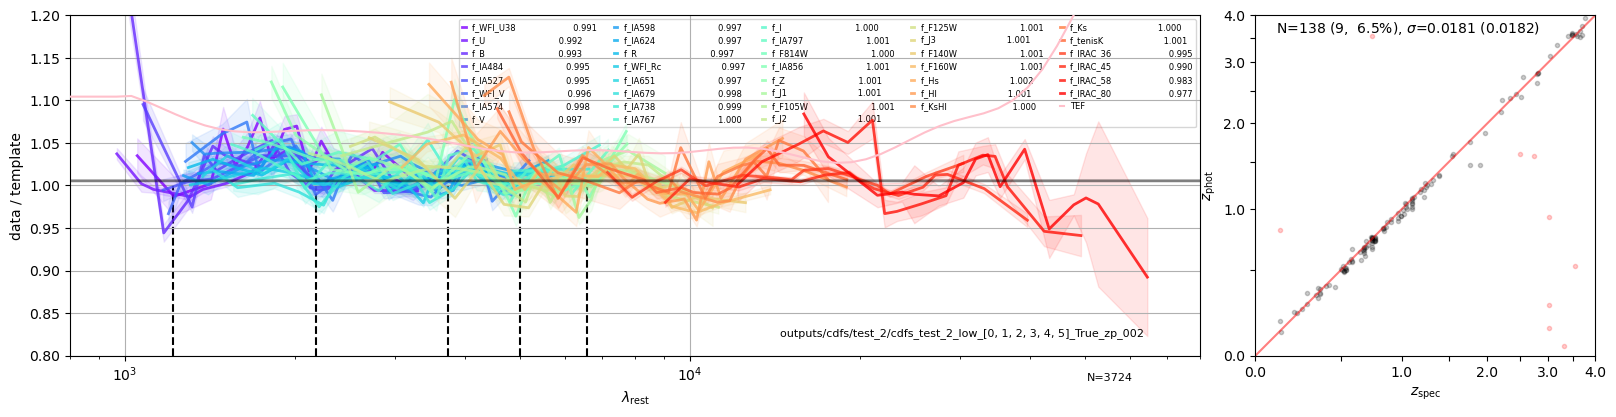

In [8]:
# Iterative Zero-point corrections

NITER = 3 # no. of iterations
NBIN = np.minimum(self.NOBJ//100, 180) # no. of bins

for iter in range(NITER):
    print('Iteration: ', iter)

    sn = self.fnu/self.efnu
    clip = (sn > 1).sum(axis=1) > 4 # Generally make this higher to ensure reasonable fits
    self.iterate_zp_templates(idx=self.idx[clip], update_templates=False,
                              update_zeropoints=True, iter=iter, n_proc=8,
                              save_templates=False, error_residuals=False,
                              NBIN=NBIN, get_spatial_offset=False)

Set sys_err = 0.00 (positive=True)


100%|██████████| 48/48 [00:07<00:00,  6.73it/s]


Compute best fits
fit_best: 0.9 s (n_proc=1,  NOBJ=3870)
Fit 8.1 s (n_proc=8, NOBJ=4000)


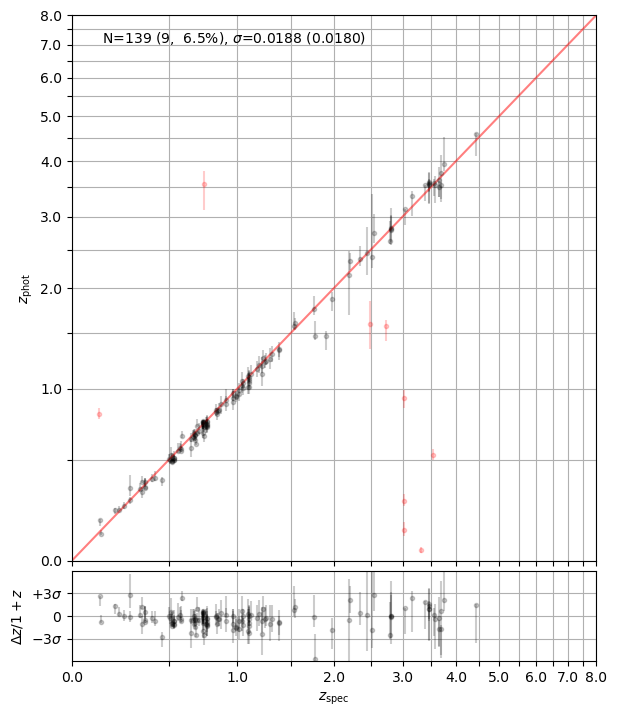

In [35]:
# Turn off error corrections derived above
self.set_sys_err(positive=True)

# Full catalog
sample = np.isfinite(self.ZSPEC)

# fit_parallel renamed to fit_catalog 14 May 2021
self.fit_catalog(self.idx[sample], n_proc=8)

# Show zspec-zphot comparison
fig = self.zphot_zspec(zmax = 8)
fig.savefig(f'outputs/{field}/{test_title}/zphot_zspec_{field}_{id_key}_{agn_sed}_{use_galaxy_templates}.png')

Total NMAD: 0.018819070018292663
Counts: [ 3  0  3  2  7  5 14 30 18 17  4  4  8 15  9]
Total: 139
NMAD: [0.41684882495867975, nan, 0.014346458276403164, 0.0, 0.018782137244375406, 0.010276249508762693, 0.010278986452272968, 0.015843950564623833, 0.017441260824822273, 0.01582241610595587, 0.005427465297254739, 0.06156438399458211, 0.054711578986796953, 0.045490295045639874, 0.033631858816150856]


C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


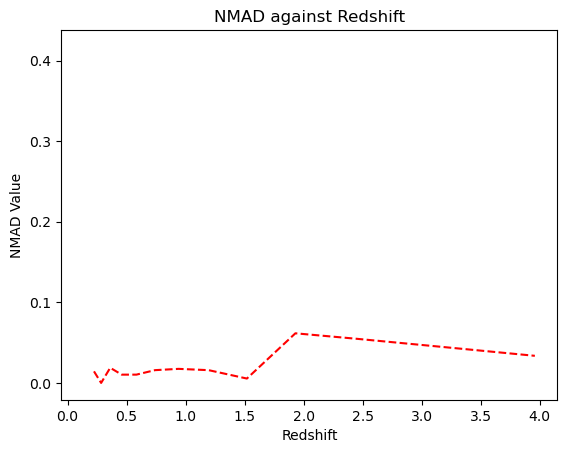

In [39]:
combined = list(zip(self.ZSPEC, self.zbest))
filtered = [(x, y) for x, y in combined if x > 0.005 and y > 0.02]
sorted_filtered = sorted(filtered, key=lambda x: x[0])
zspec_sorted, zphot_sorted = zip(*sorted_filtered)

#total NMAD
dz = (np.array(zphot_sorted) - np.array(zspec_sorted)) / (1 + np.array(zspec_sorted))
total_nmad = astropy.stats.mad_std(dz)
print(f'Total NMAD: {total_nmad}')

#outliers
cat_count = len(dz)
outliers = np.abs(dz) >= 0.15 # 0.15 is catostrophic_outlier in eazy code
outliers_count = sum(outliers)

no_of_bins = 15 # no. of bins

logbins_start = np.log10(min(zspec_sorted)) # using logarithmic bins
logbins_end = np.log10(max(zspec_sorted)) + 1e-10 # adding a small value to include the last value
logbins = np.logspace(logbins_start, logbins_end, num=no_of_bins+1)
counts, bins = np.histogram(zspec_sorted, bins=logbins)
print(f'Counts: {counts}')
print(f'Total: {len(zspec_sorted)}')


last_val = 0
nmad_val = []
for bin in range(no_of_bins):
    new_val = last_val + counts[bin]-1
    zspec_val = zspec_sorted[last_val:new_val]
    zphot_val = zphot_sorted[last_val:new_val]
    dz = (np.array(zphot_val) - np.array(zspec_val)) / (1 + np.array(zspec_val))
    nmad_val.append(astropy.stats.mad_std(dz))
    last_val = new_val + 1
print(f'NMAD: {nmad_val}')

bin_centers = (np.array(bins[:-1]) + np.array(bins[1:])) / 2
plt.clf()
plt.plot(bin_centers, nmad_val, 'r--')  # 'r--' specifies a red dashed line

plt.xlabel('Redshift')
plt.ylabel('NMAD Value')


plt.title('NMAD against Redshift')

plt.savefig(f'outputs/{field}/{test_title}/nmad_{field}_{id_key}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

In [41]:
# Saving Key data to csv
key_data = pd.DataFrame(columns=headings)
key_data.loc[0] = [id_key, loop_number, agn_sed, use_galaxy_templates, total_count, total_agn, total_agn/total_count, ir_count, ir_percent, radio_count, radio_percent, xray_count, xray_percent, mean_frac, cat_count, outliers_count, total_nmad, nmad_val]
key_data.to_csv(key_data_file, mode='a', index=False, header=False)

In [13]:
# there is more cells in the example ipy, but they are not needed for this project, they include UVJ, SED and saving zout files.
#that's all folks